Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
#sys.path.append("../scripts/")

from sklearn.model_selection import train_test_split

# custom modules import
#from visualization import Plotters
#from causalgraph import CausalGraph
#from cleaning import CleanDataFrame
#cleaner = CleanDataFrame()

In [2]:
#load data
data=pd.read_csv("../data/merged_data.csv")

In [3]:
data.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng', 'Trip ID',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'Trip_Origin_lat', 'Trip_Origin_lng', 'Trip_Destination_lat',
       'Trip_Destination_lng', 'distance', 'day_of_month', 'weekday',
       'month_pick', 'hour_pick', 'duration', 'Holiday'],
      dtype='object')

In [4]:

columns=['order_id','lat','lng','Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time']
data.drop(columns, inplace=True, axis=1)

In [5]:
data.head(5)

,id,driver_id,driver_action,Trip ID,Trip_Origin_lat,Trip_Origin_lng,Trip_Destination_lat,Trip_Destination_lng,distance,day_of_month,weekday,month_pick,hour_pick,duration,Holiday
0,1,243828,accepted,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,Thursday,7.0,9.0,217.0,False
1,2,243588,rejected,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,Thursday,7.0,9.0,217.0,False
2,3,243830,rejected,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,Thursday,7.0,9.0,217.0,False
3,4,243539,rejected,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,Thursday,7.0,9.0,217.0,False
4,5,171653,rejected,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,Thursday,7.0,9.0,217.0,False


In [2]:
#data.to_csv("../data/final_data.csv", index=False)
data=pd.read_csv("../data/final_data.csv")

First, we must create an empty structure model.

In [3]:

import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

/home/sucess/anaconda3/envs/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Causal graph Sample

We can add these relationships into our structure model:

In [4]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [5]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

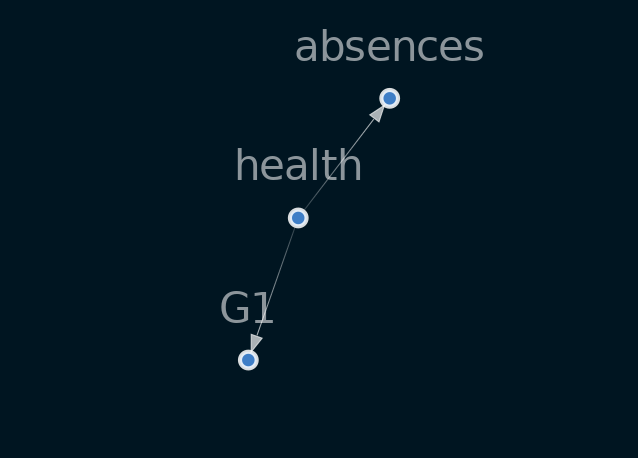

In [6]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

Preparing the Data for Structure Learning

In [11]:
data=pd.read_csv("../data/final_data.csv")

In [7]:
data.dropna(inplace = True)

In [8]:

import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['driver_action', 'weekday', 'Holiday']


In [9]:
struct_data.isnull().sum()

id                      0
driver_id               0
driver_action           0
Trip ID                 0
Trip_Origin_lat         0
Trip_Origin_lng         0
Trip_Destination_lat    0
Trip_Destination_lng    0
distance                0
day_of_month            0
weekday                 0
month_pick              0
hour_pick               0
duration                0
Holiday                 0
dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,id,driver_id,driver_action,Trip ID,Trip_Origin_lat,Trip_Origin_lng,Trip_Destination_lat,Trip_Destination_lng,distance,day_of_month,weekday,month_pick,hour_pick,duration,Holiday
0,1,243828,0,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,4,7.0,9.0,217.0,0
1,2,243588,1,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,4,7.0,9.0,217.0,0
2,3,243830,1,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,4,7.0,9.0,217.0,0
3,4,243539,1,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,4,7.0,9.0,217.0,0
4,5,171653,1,392001,6.601042,3.276634,6.450107,3.391615,20.984319,1.0,4,7.0,9.0,217.0,0


In [12]:
#We can now apply the NOTEARS algorithm to learn the structure.
from causalnex.structure.notears import from_pandas
sm = from_pandas(struct_data.head(5000))

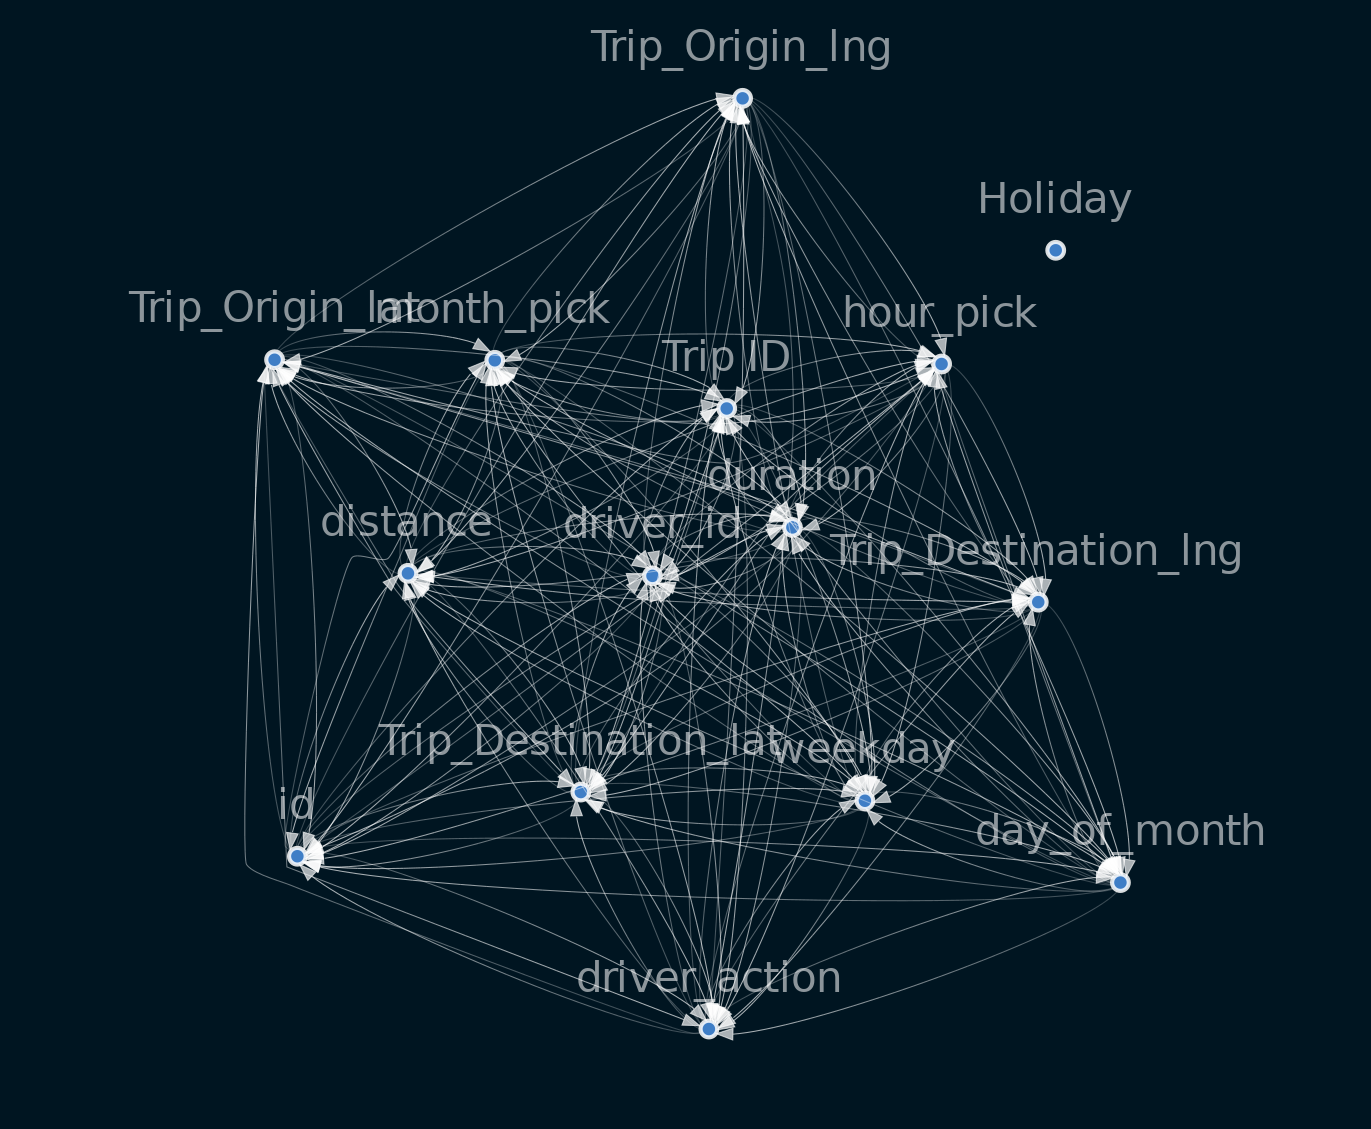

In [14]:

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

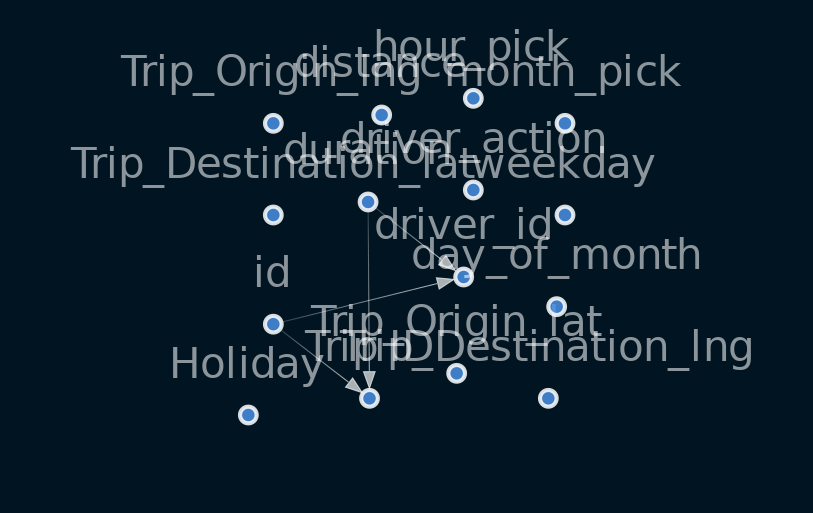

In [25]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [27]:
sm = from_pandas(struct_data, tabu_edges=[("day_of_month", "Holiday")], w_threshold=0.8)

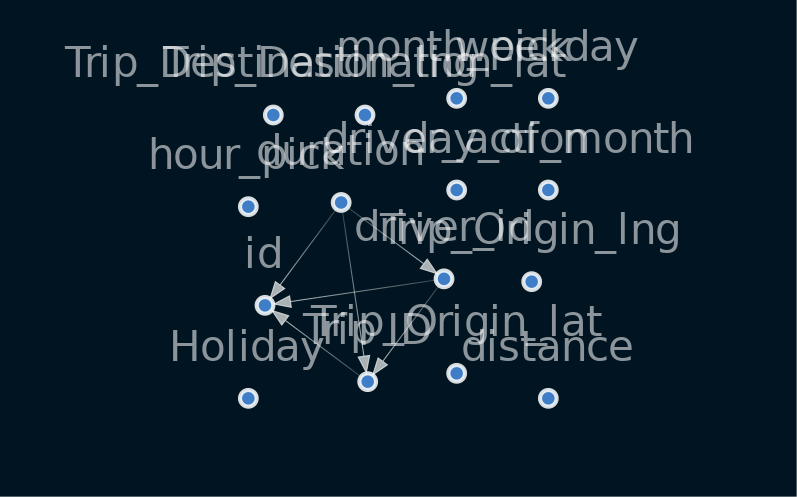

In [28]:
# changing to numeric values 
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [ ]:
=============//================